# Dataset Link:

https://data.mendeley.com/datasets/32b5vfj6tc/1

# Import Library

In [1]:
import os
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from torchvision.io import read_image
from PIL import Image
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:
print(device)
print("Device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU Only")


cuda
Device: NVIDIA GeForce RTX 3060 Laptop GPU


# Preprocessing

In [3]:
transform = {
    "train": transforms.Compose([
        transforms.Resize((600, 600)),
        # transforms.RandomHorizontalFlip(),
        # transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    "val_test": transforms.Compose([
        transforms.Resize((600, 600)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

# Dataset

In [80]:
# data_dir = 'dataset'
# full_dataset = ImageFolder(root=data_dir, transform=transform['train'])

# train_size = int(0.7 * len(full_dataset))
# val_size = int(0.15 * len(full_dataset))
# test_size = len(full_dataset) - train_size - val_size

# train_dataset, val_dataset, test_dataset = random_split(
#     full_dataset, [train_size, val_size, test_size],
#     generator=torch.Generator().manual_seed(42)
# )

# val_dataset.dataset.transform = transform['val_test']
# test_dataset.dataset.transform = transform['val_test']
# batch_size = 16

# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=batch_size)
# test_loader = DataLoader(test_dataset, batch_size=batch_size)


In [4]:
# 3. Load Dataset dan Split
data_dir = "datasets"  # folder dengan subfolder `defective/` dan `normal/`
dataset = ImageFolder(root=data_dir, transform=transform["train"])

# Split dataset
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])
val_data.dataset.transform = transform["val_test"]
test_data.dataset.transform = transform["val_test"]

# DataLoader
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16, shuffle=False)
test_loader = DataLoader(test_data, batch_size=16, shuffle=False)


In [82]:
print(f"Total data: {len(dataset)}")
print(f"Training data: {len(train_data)}")
print(f"Validation data: {len(val_data)}")
print(f"Test data: {len(test_data)}")

Total data: 1698
Training data: 1188
Validation data: 254
Test data: 256


# Model

In [83]:
# 4. Load EfficientNet-B7 Pretrained
from torchvision.models import efficientnet_b7, EfficientNet_B7_Weights
from torchsummary import summary
weights = EfficientNet_B7_Weights.DEFAULT
model = efficientnet_b7(weights=weights)

# Freeze all pretrained layers
for param in model.parameters():
    param.requires_grad = False

# Replace classifier head
num_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(num_features, 2)  # 2 classes: defective, normal
)

model = model.to(device)
summary(model, input_size=(3, 600, 600))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 300, 300]           1,728
       BatchNorm2d-2         [-1, 64, 300, 300]             128
              SiLU-3         [-1, 64, 300, 300]               0
            Conv2d-4         [-1, 64, 300, 300]             576
       BatchNorm2d-5         [-1, 64, 300, 300]             128
              SiLU-6         [-1, 64, 300, 300]               0
 AdaptiveAvgPool2d-7             [-1, 64, 1, 1]               0
            Conv2d-8             [-1, 16, 1, 1]           1,040
              SiLU-9             [-1, 16, 1, 1]               0
           Conv2d-10             [-1, 64, 1, 1]           1,088
          Sigmoid-11             [-1, 64, 1, 1]               0
SqueezeExcitation-12         [-1, 64, 300, 300]               0
           Conv2d-13         [-1, 32, 300, 300]           2,048
      BatchNorm2d-14         [-1, 32, 3

In [84]:
# from torchvision.models import efficientnet_b7, EfficientNet_B7_Weights
# from torchsummary import summary

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model = efficientnet_b7(weights=EfficientNet_B7_Weights.IMAGENET1K_V1)
# for param in model.parameters():
#     param.requires_grad = False  # Freeze backbone

# model.classifier[1] = nn.Linear(model.classifier[1].in_features, 2)
# model = model.to(device)

# summary(model, input_size=(3, 600, 600))

# Parameter


In [85]:
criterion =  nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001)
epochs = 50



In [86]:
train_losses = []
val_losses = []
val_accuracies = []
train_accuracies = []

In [87]:
best_val_loss = float('inf')
for epoch in range(epochs):
    model.train()
    train_loss = 0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        preds = outputs.argmax(dim=1)
        correct_train += (preds == labels).sum().item()
        total_train += labels.size(0)

    train_acc = correct_train / total_train

    # Validation
    model.eval()
    val_loss = 0
    correct_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct_val += (preds == labels).sum().item()

    val_acc = correct_val / len(val_data)

    # Simpan history
    train_losses.append(train_loss / len(train_loader))
    val_losses.append(val_loss / len(val_loader))
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}, Train Acc = {train_acc:.4f}, Val Acc = {val_acc:.4f}")

    # Save best model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_model.pth")


Epoch 1: Train Loss = 30.9488, Val Loss = 4.4052, Train Acc = 0.8569, Val Acc = 0.9370
Epoch 2: Train Loss = 19.3937, Val Loss = 3.3492, Train Acc = 0.9217, Val Acc = 0.9409
Epoch 3: Train Loss = 15.8854, Val Loss = 3.0505, Train Acc = 0.9175, Val Acc = 0.9370
Epoch 4: Train Loss = 14.3117, Val Loss = 2.8964, Train Acc = 0.9327, Val Acc = 0.9449
Epoch 5: Train Loss = 14.1612, Val Loss = 2.7354, Train Acc = 0.9360, Val Acc = 0.9409
Epoch 6: Train Loss = 13.8043, Val Loss = 2.6578, Train Acc = 0.9352, Val Acc = 0.9370
Epoch 7: Train Loss = 12.2381, Val Loss = 2.5596, Train Acc = 0.9461, Val Acc = 0.9488
Epoch 8: Train Loss = 11.2909, Val Loss = 2.4912, Train Acc = 0.9512, Val Acc = 0.9449
Epoch 9: Train Loss = 12.6584, Val Loss = 2.4746, Train Acc = 0.9428, Val Acc = 0.9488
Epoch 10: Train Loss = 12.0431, Val Loss = 2.4713, Train Acc = 0.9470, Val Acc = 0.9370
Epoch 11: Train Loss = 9.1692, Val Loss = 2.3415, Train Acc = 0.9663, Val Acc = 0.9449
Epoch 12: Train Loss = 10.9367, Val Loss =

# Evaluation

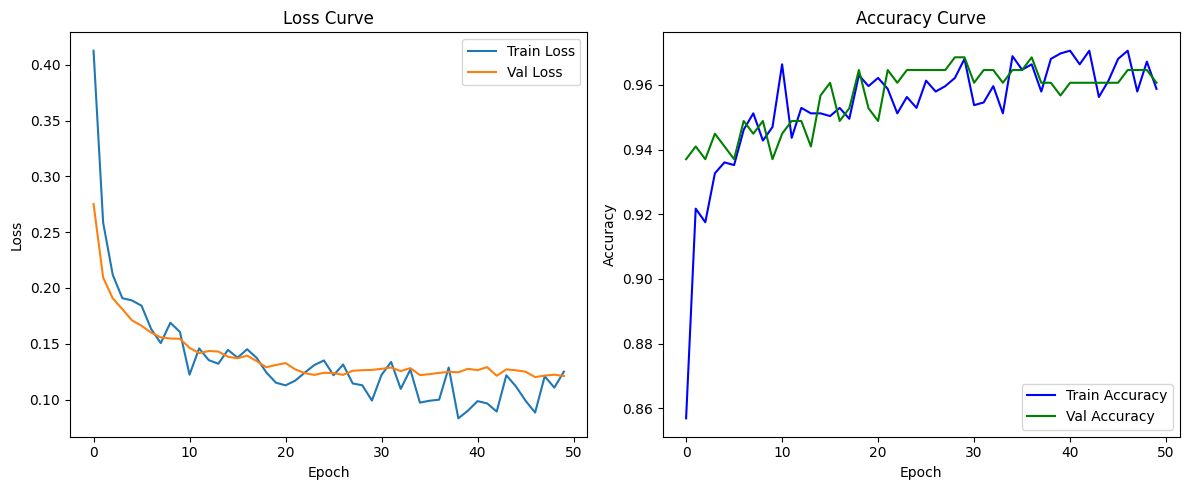

In [88]:
import matplotlib.pyplot as plt

# Plot Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy', color='blue')
plt.plot(val_accuracies, label='Val Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()


In [89]:
# 7. Evaluasi di Test Set
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

print(f"Test Accuracy: {correct / total:.4f}")


Test Accuracy: 0.9688



Classification Report:

              precision    recall  f1-score   support

   Defective       0.97      0.97      0.97       127
        Good       0.97      0.97      0.97       129

    accuracy                           0.97       256
   macro avg       0.97      0.97      0.97       256
weighted avg       0.97      0.97      0.97       256



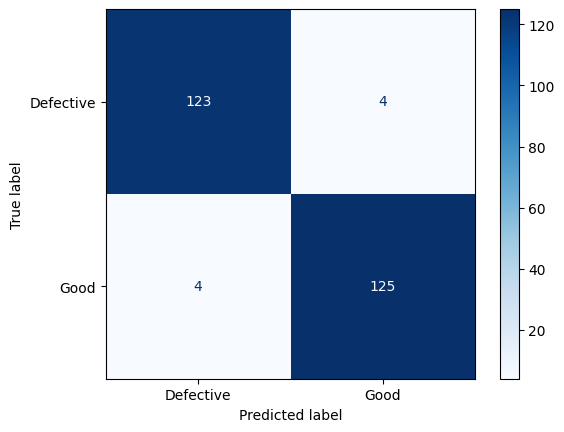

In [107]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Kumpulkan semua label dan prediksi
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)
disp.plot(cmap='Blues', values_format='d')

# Classification Report
print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, target_names=dataset.classes))


In [8]:
from torchvision.models import efficientnet_b7, EfficientNet_B7_Weights

# Load weights untuk inisialisasi struktur awal
weights = EfficientNet_B7_Weights.DEFAULT
model = efficientnet_b7(weights=weights)

# Replace classifier head (sesuai training)
num_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(num_features, 2)  # 2 classes: defective, normal
)

model = model.to(device)
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.eval()


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
            (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormAct

In [9]:
from PIL import Image
import matplotlib.pyplot as plt
import torch

def predict_image(image_path):
    model.eval()

    # Load and transform image
    image = Image.open(image_path).convert("RGB")
    transform_fn = transform["val_test"]
    image_tensor = transform_fn(image).unsqueeze(0).to(device)

    # Predict
    with torch.no_grad():
        output = model(image_tensor)
        pred = output.argmax(dim=1).item()
        predicted_label = dataset.classes[pred]

    # Show image with prediction
    plt.imshow(image)
    plt.title(f"Predicted: {predicted_label}")
    plt.axis("off")
    plt.show()

    return predicted_label


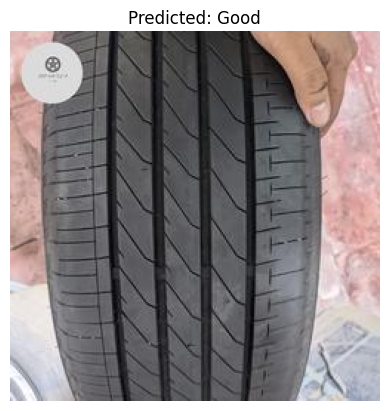

Predicted: Good


In [11]:
image_path = r"TestModel\apik1.jpg"
predicted_class = predict_image(image_path)
print("Predicted:", predicted_class)

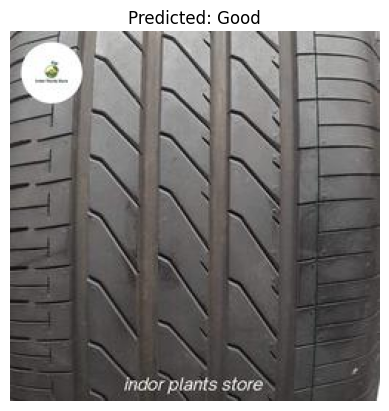

Predicted: Good


In [12]:
image_path = r"TestModel\apik2.jpg"
predicted_class = predict_image(image_path)
print("Predicted:", predicted_class)

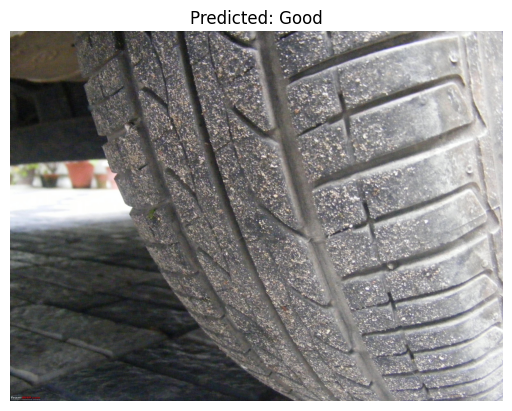

Predicted: Good


In [13]:
image_path = r"TestModel\bagus.jpg"
predicted_class = predict_image(image_path)
print("Predicted:", predicted_class)

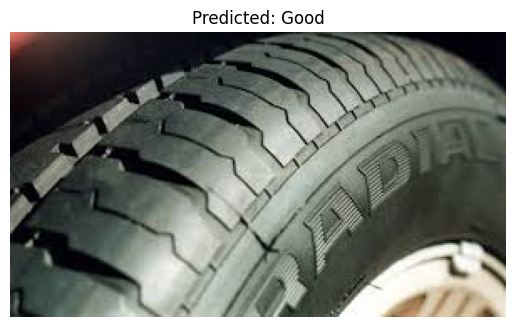

Predicted: Good


In [15]:
image_path = r"TestModel/bagus.jfif"
predicted_class = predict_image(image_path)
print("Predicted:", predicted_class)

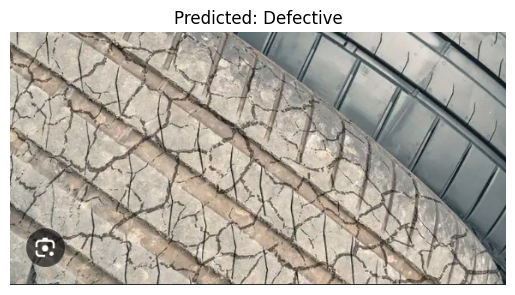

Predicted: Defective


In [16]:
image_path = r"TestModel\image.png"
predicted_class = predict_image(image_path)
print("Predicted:", predicted_class)

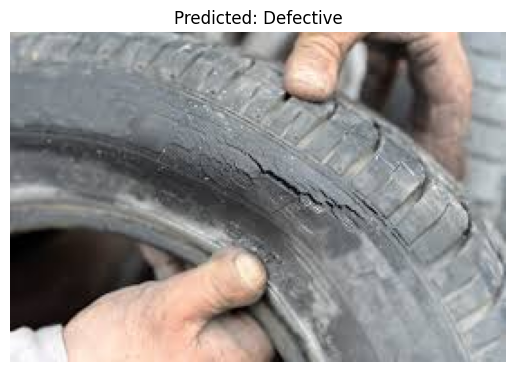

Predicted: Defective


In [17]:
image_path = r"TestModel\rusak.jfif"
predicted_class = predict_image(image_path)
print("Predicted:", predicted_class)

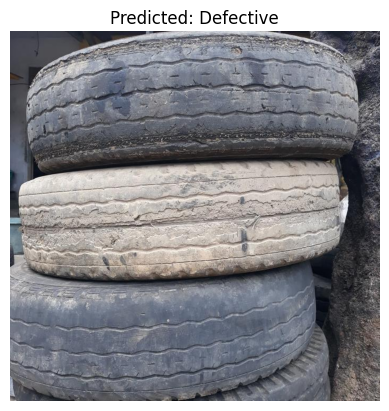

Predicted: Defective


In [18]:
image_path = r"TestModel\rusak.jpg"
predicted_class = predict_image(image_path)
print("Predicted:", predicted_class)

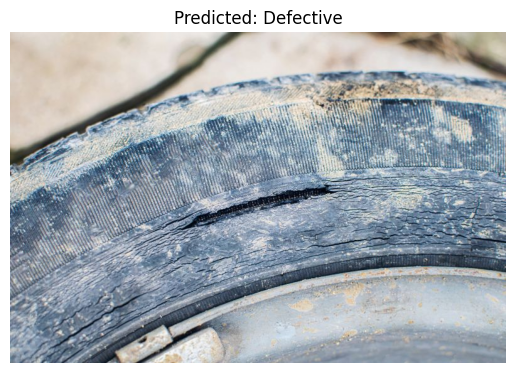

Predicted: Defective


In [19]:
image_path = r"TestModel\rusak1.jpg"
predicted_class = predict_image(image_path)
print("Predicted:", predicted_class)